In [44]:
import QuantLib as ql
from helper import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# Set valuation date
today = ql.Date(30, ql.September, 2022)
ql.Settings.instance().evaluationDate = today

In [11]:
# Create JPY1D yield curve
jpy1d = createYieldCurve("MarketDataBook.xlsx", "JPY1D", "DiscountFactor")
# Create TOPIX Dividend curve
tpxDVD = createForwardCurve("MarketDataBook.xlsx", "TPX_DVD", "DividendYield")
# Create TOPIX Vola surface
volaSurface = createVolaSurface(today, "MarketDataBook.xlsx", "TPX_Vola")
# TOPIX Spot price
spot = ql.QuoteHandle(ql.SimpleQuote(1835.94))


## Plot Vola Surface

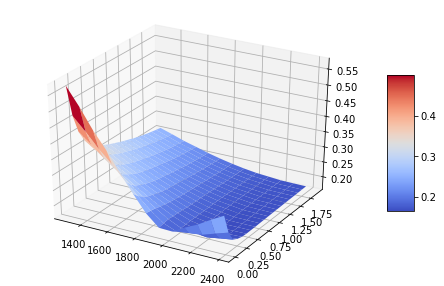

In [48]:
plot_expiries = np.arange(0, 2, 0.1)
plot_strikes = spot.value() * np.arange(0.7, 1.3, 0.05)
X, Y = np.meshgrid(plot_strikes, plot_expiries)
Z = np.array([volaSurface.blackVol(y, x) for xr, yr in zip(X, Y) for x, y in zip(xr, yr)]).reshape((len(X), len(X[0])))

fig = plt.figure(figsize=(8, 5))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X,Y,Z, cmap = cm.coolwarm, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5);

## Heston Model

The dynamics of an underlying asset under Heston model are 
$$dS_t = \mu S_t dt + \sqrt{V_t} S_t dW_t^1$$

where the variance $V_t$ of the underlying is itself a stochastic process (CIR SDE)
$$dV_t = \kappa (\theta - V_t) + \sigma \sqrt{V_t} dW_t^2$$

and the two Wiener processes are correlated
$$dW_1 dW_2 = \rho dt$$

In [4]:
# Underlying details (TOPIX)

v0 = 0.2 ** 2
kappa = v0 # spead of mean reversion
theta = 0.2 # mean reversion / kappa
sigma = 0.1 # volatility of the volatility
rho = -0.75 # correlation of wiener processes



In [5]:
# Create Heston process
heston_process = ql.HestonProcess(jpy1d, tpxDVD, spot, v0, kappa, theta, sigma, rho)

## Heston Model Calibration

In [49]:
model = ql.HestonModel(heston_process)
engine = ql.AnalyticHestonEngine(model)

In [57]:
helpers = []
volaSurface.setInterpolation("bilinear")
calibrationStrikes = np.arange(volaSurface.minStrike(), volaSurface.maxStrike(), (volaSurface.maxStrike() - volaSurface.minStrike()) / 10)
calibrationExpiry = ql.Date(31, 3, 2023)
for strike in calibrationStrikes:
    # Vola for selected instrument
    curVol = ql.QuoteHandle(ql.SimpleQuote(volaSurface.blackVol(calibrationExpiry, strike)))
    # time to expiry
    p = ql.Period(calibrationExpiry - today, ql.Days)
    helper = ql.HestonModelHelper(p, ql.NullCalendar(), spot, strike, curVol, )

0.4569268109917935
0.39755568886729015
0.3447426629792398
0.2966551575016743
0.2524126436134352
0.21256311872174805
0.18117166544566243
0.16636449961065655
0.16774141314138452
0.17668162434065096


In [56]:
calibrationStrikes

array([ 917.97 , 1101.564, 1285.158, 1468.752, 1652.346, 1835.94 ,
       2019.534, 2203.128, 2386.722, 2570.316])